In [74]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Data Cleaning and EDA

In [79]:
# First 5 rows of raw dataset
df = pd.read_csv('customer_support_tickets.csv')
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [80]:
# Dataset size
print("Number of rows: " + str(df.shape[0]))
print("Number of columns: " + str(df.shape[1]))

Number of rows: 8469
Number of columns: 17


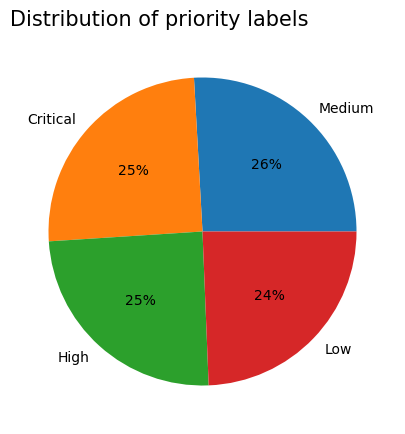

The four types of priority labels are: ['Critical' 'Low' 'High' 'Medium']


In [99]:
# EDA  of Ticket Priority column
count_labels = df['Ticket Priority'].value_counts()

plt.figure(figsize = (10,5))
plt.pie(count_labels, labels = count_labels.index, autopct='%.0f%%')
plt.title('Distribution of priority labels', loc = 'left', pad = 10, size = 15)
plt.show()
print("The four types of priority labels are: " + str(df['Ticket Priority'].unique()))

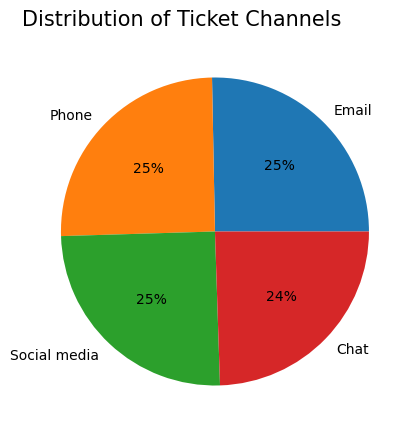

Out of 8469 tickets,
2073 tickets are through the chat


In [98]:
# EDA of Ticket Channel column
count_ticket_channel = df['Ticket Channel'].value_counts()

plt.figure(figsize = (10,5))
plt.pie(count_ticket_channel, labels = count_ticket_channel.index, autopct='%.0f%%')
plt.title('Distribution of Ticket Channels', loc = 'left', pad = 10, size = 15)
plt.show()

print("Out of " + str(df.shape[0]) + " tickets,")
print(str(df[df['Ticket Channel'] == 'Chat'].shape[0]) + " tickets are through the chat")

In [104]:
# First 5 rows of relavent rows
cleaned_df = df[df['Ticket Channel'] == 'Chat'][['Ticket Description', 'Ticket Priority']]
cleaned_df

,Ticket Description,Ticket Priority
1,I'm having an issue with the {product_purchase...,Critical
11,I'm having an issue with the {product_purchase...,High
12,I'm having an issue with the {product_purchase...,Low
13,"I've recently set up my {product_purchased}, b...",Low
14,I'm having an issue with the {product_purchase...,High
...,...,...
8448,"I've recently set up my {product_purchased}, b...",Medium
8450,I'm having an issue with the {product_purchase...,Low
8453,The {product_purchased} is unable to establish...,High
8457,I'm having an issue with the {product_purchase...,High


In [106]:
def remove_filler(text):
    return text.replace("I'm having an issue with the {product_purchased}. Please assist.", "")
cleaned_df['Ticket Description'] = cleaned_df['Ticket Description'].apply(remove_filler)
cleaned_df.iloc[0]['Ticket Description']

"\n\nIf you need to change an existing product.\n\n\n\nIf The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly."

In [107]:
#Ticket Description cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub('[({})?/$#|=]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[.]', ' ', text)
    text = re.sub('[->]', ' ', text)
    text = re.sub('[:]', ' ', text)
    text = re.sub('[_]', ' ', text)
    text = re.sub('[,]', ' ', text)
    text = re.sub('[-]', ' ', text)
    text = re.sub('[\']', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned_df['Ticket Description'] = cleaned_df['Ticket Description'].apply(clean_text)
cleaned_df.iloc[0]['Ticket Description']

'if you need to change an existing product if the issue im facing is intermittent  sometimes it works fine  but other times it acts up unexpectedly '

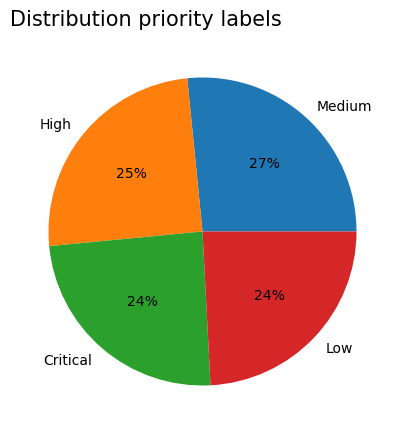

In [97]:
#EDA of cleaned Ticket Priority distribution
count_labels = cleaned_df['Ticket Priority'].value_counts()

plt.figure(figsize = (10,5))
plt.pie(count_labels, labels = count_labels.index, autopct='%.0f%%')
plt.title('Distribution priority labels', loc = 'left', pad = 10, size = 15)
plt.show()

# Model Training

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Subset
from transformers import BertTokenizerFast
from tqdm.notebook import tqdm

# Load the dataset
data = pd.read_csv('customer_support_tickets.csv')
data = data[['Ticket Description', 'Ticket Priority']]

# Define dataset class
class CustomTicketDataset(torch.utils.data.Dataset):
    def __init__(self, data, model_name="bert-base-uncased"):
        self.data = data
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        self.labels = data['Ticket Priority']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        description = str(self.data.iloc[idx]['Ticket Description'])
        label = self.labels[idx]
        encoding = self.tokenizer(description, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.1)

train_dataset = CustomTicketDataset(train_data)
test_dataset = CustomTicketDataset(test_data)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define model architecture
class TicketClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TicketClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

# Initialize model, optimizer, and loss function
model = TicketClassifier(num_classes=16)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
progress_bar = tqdm(range(epochs), desc="Epoch")
for epoch in progress_bar:
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Training Loss': '{:.4f}'.format(loss.item())})

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: {:.2f}%'.format(100 * correct / total))

KeyboardInterrupt: 